### Workspace Prep

In [65]:
import torch
import torch.nn as nn
import torch.nn.functional as fn
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader
from torch.autograd import Variable 

from sklearn.preprocessing import StandardScaler, MinMaxScaler

import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger as TensorBoardLogger

import tensorboard

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sys
import tqdm as notebook_tqdm



# caution: path[0] is reserved for script path (or '' in REPL)
sys.path.insert(1, r'D:\Documents\GitHub\itcs-8156\utils')
sys.path.insert(1, r'D:\Documents\GitHub\itcs-8156\lstm')
sys.path.insert(1, r'H:\My Drive\SP23\ML\envs\groupWork\utils')
sys.path.insert(1, r'H:\My Drive\SP23\ML\envs\groupWork\lstm')

import preprocessing as pp
from preprocessing import (market_prepro,
                           lstm_timeseries_feat_and_targ,
                           
)

plt.style.use('ggplot')

%load_ext autoreload
%autoreload 2

from lstm_model import (BasicLSTM, matrixLSTM)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Uncomment below to install missing modules

In [66]:
# !pip install ipywidgets

In [67]:
# pip install tensorboard

In [68]:
# pip install --ignore-installed PyYAML  # might be necessary to run before installing pytorch

In [69]:
# pip install pytorch-lightning

In [70]:
# pip install torch

### Load and Pre-processs Stock Data

In [71]:
df_sb = pd.read_csv('SBUX.csv', index_col='Date', parse_dates=True)

In [72]:
display(df_sb)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-12-11,86.260002,86.870003,85.849998,86.589996,81.116577,4921900
2019-12-12,88.000000,88.889999,87.540001,88.209999,82.634186,10282100
2019-12-13,88.019997,88.790001,87.580002,88.669998,83.065117,6714100
2019-12-16,89.139999,89.300003,88.430000,88.779999,83.168152,6705600
2019-12-17,88.870003,88.970001,87.470001,88.129997,82.559242,7296900
...,...,...,...,...,...,...
2020-12-04,101.349998,102.940002,101.070000,102.279999,97.790939,6952700
2020-12-07,102.010002,102.220001,100.690002,101.410004,96.959137,4514800
2020-12-08,100.370003,101.570000,100.010002,101.209999,96.767899,3911300


<Axes: title={'center': 'Starbucks Sales Volume'}, xlabel='Date'>

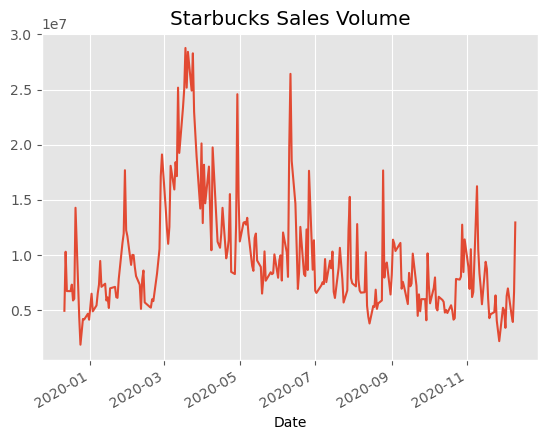

In [73]:
df_sb['Volume'].plot(title='Starbucks Sales Volume')

In [74]:
%autoreload 2

def processdata(df, day_feat, day_targ):
    df_scaled = pp.std_values(df, 'minmax')

    X_train, X_test, T_train, T_test = pp.split_data_validate(df_scaled, 'Volume')

    dl_train, ds_train = pp.lstm_timeseries_feat_and_targ(X_train, T_train, day_feat, day_targ, None )
    dl_test, ds_test = pp.lstm_timeseries_feat_and_targ(X_test, T_test, day_feat, day_targ, None)

    return dl_train, ds_train, dl_test, ds_test

def train_model(model, data, epochs, logger_name):
    logger = TensorBoardLogger("lightning_logs", name=logger_name)
    trainer = pl.Trainer(max_epochs=epochs, logger=logger)

    trainer.fit(model, train_dataloaders=data)
    trainer.test(model, dataloaders=dl_test)

dl_train, ds_train, dl_test, ds_test = processdata(df_sb, 3, 0)



## Test Our LSTM Model On Starbucks Data

In [75]:
%autoreload 2

our_model = BasicLSTM(num_feat=5, num_hiddens=1, num_out=1, lr=0.01)

train_model(our_model, dl_train, 1, 'our_model')

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

  | Name | Type | Params
------------------------------
------------------------------
32        Trainable params
0         Non-trainable params
32        Total params
0.000     Total estimated model params size (MB)
The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_loss_epoch       0.014627916340515848
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


In [76]:
%autoreload 2

our_model_matrix = matrixLSTM(num_feat=5, num_hiddens=1, num_out=1, lr=0.01)

train_model(our_model_matrix, dl_train, 25, 'matrix_model')

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name | Type | Params
------------------------------
------------------------------
32        Trainable params
0         Non-trainable params
32        Total params
0.000     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=25` reached.


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_loss_epoch       0.012634466739635773
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


### Build Pytorch LSTM Model

In [77]:
class LSTMval(pl.LightningModule):
    def __init__(self, num_feat, num_hiddens, num_layers, lr):
        super().__init__()
        self.num_layers = num_layers #number of layers
        self.input_size = num_feat #input size
        self.hidden_size = num_hiddens #hidden state
        # self.seq_length = seq_length #sequence length
        self.lr = lr
        self.lstm = nn.LSTM(input_size=self.input_size, hidden_size=self.hidden_size,
                          num_layers=self.num_layers, batch_first=True) #lstm
    
    def forward(self,x):
        # h_0 = Variable(torch.zeros(self.num_layers, self.hidden_size)) #hidden state
        # c_0 = Variable(torch.zeros(self.num_layers, self.hidden_size)) #internal state
        # print(h_0,c_0)
        # Propagate input through LSTM
        output, (hn, cn) = self.lstm(x) #lstm with input, hidden, and internal state
        return output
    

    def configure_optimizers(self):
        return torch.optim.NAdam(self.parameters(), lr = self.lr)
    
    def training_step(self,batch,batch_idx):
        input_i, label_i = batch
        # print(input_i[0],torch.transpose(input_i[0],0,1))
        output_i = self.forward(torch.transpose(input_i[0],0,1))[0]
        
        loss = (output_i - label_i)**2
        
        self.log("training loss", loss, logger=True)
        
        return loss
    
    def test_step(self, batch, batch_idx):
        input_i, label_i = batch
        output_i = self.forward(torch.transpose(input_i[0],0,1))[0]
        test_loss = (output_i - label_i)**2
        
        self.log("test_loss", test_loss, on_step=True, logger=True)

    def makepred(self, dataset):
        y = []
        t = []

        h_hist=[]
        c_hist=[]
        x_hist=[]

        for ii in dataset:
            input_i, lab = ii

            y_i = self.forward(torch.transpose(input_i,0,1))[0]

            y_i = (y_i.detach().numpy())

            y.append(y_i)
            t.append(lab.numpy())

        return y, t


### Test Pytorch LSTM Model on Starbucks Data

In [78]:
val_mdl = LSTMval(num_feat = 5, num_hiddens = 1, num_layers = 1, lr = 0.01).double()
# logger = TensorBoardLogger("lightning_logs", name="SBUX")
# trainer = pl.Trainer(max_epochs=3,logger=logger)
# trainer.fit(val_mdl, train_dataloaders =dl_train)

train_model(val_mdl, dl_train, 25, 'val_model')


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name | Type | Params
------------------------------
0 | lstm | LSTM | 32    
------------------------------
32        Trainable params
0         Non-trainable params
32        Total params
0.000     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=25` reached.


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_loss_epoch       0.012449094335328275
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


In [79]:
y_train_val, t_train_val = val_mdl.makepred(ds_train)
y_test_val, t_test_val = val_mdl.makepred(ds_test)

y_train_our, t_train_our = our_model.makepred(ds_train)[0:2]
y_test_our, t_test_our = our_model.makepred(ds_test)[0:2]

y_train_mat, t_train_mat = our_model_matrix.makepred(ds_train)
y_test_mat, t_test_mat = our_model_matrix.makepred(ds_test)



In [97]:
def plot_results(t_train, t_test, y_train, y_test):
    fig, axs = plt.subplots(1,2)
    fig.set_figheight(10)
    fig.set_figwidth(15)

    axs[0].scatter(y_train, t_train)
    axs[0].set_title('Training')
    axs[0].set_ylabel('True Value')
    axs[0].set_xlabel('Predicted Value')

    axs[1].scatter(y_test, t_test)
    axs[1].set_title('Testing')
    axs[1].set_ylabel('True Value')
    axs[1].set_xlabel('Predicted Value')

def plot_results_time(t_train, t_test, Y):
    fig = plt.figure()
    fig.set_figheight(10)
    fig.set_figwidth(15)

    t = np.concatenate((t_train,t_test))
    # plt.plot(range(0,len(t)), t, label='Actual Data')
    for kk in Y.keys():
        print(kk)
        plt.plot(range(0,len(t)), Y[kk], label=kk, linewidth=3)

    plt.ylabel('Prediction')
    plt.xlabel('Time')

    plt.legend(prop={'size': 20})


In [81]:
from sklearn.metrics import (r2_score, mean_absolute_percentage_error)


def test_r2(t_train, t_test, y_train, y_test):

    train_r2 = r2_score(t_train, y_train)
    test_r2 = r2_score(t_test, y_test)

    print('The r2 training score is ', train_r2)
    print('The r2 testing score is ', test_r2)

def test_mape(t_train, t_test, y_train, y_test):

    train_mape = mean_absolute_percentage_error(t_train, y_train)
    test_mape = mean_absolute_percentage_error(t_test, y_test)

    print('The mape training score is ', train_mape)
    print('The mape testing score is ', test_mape)

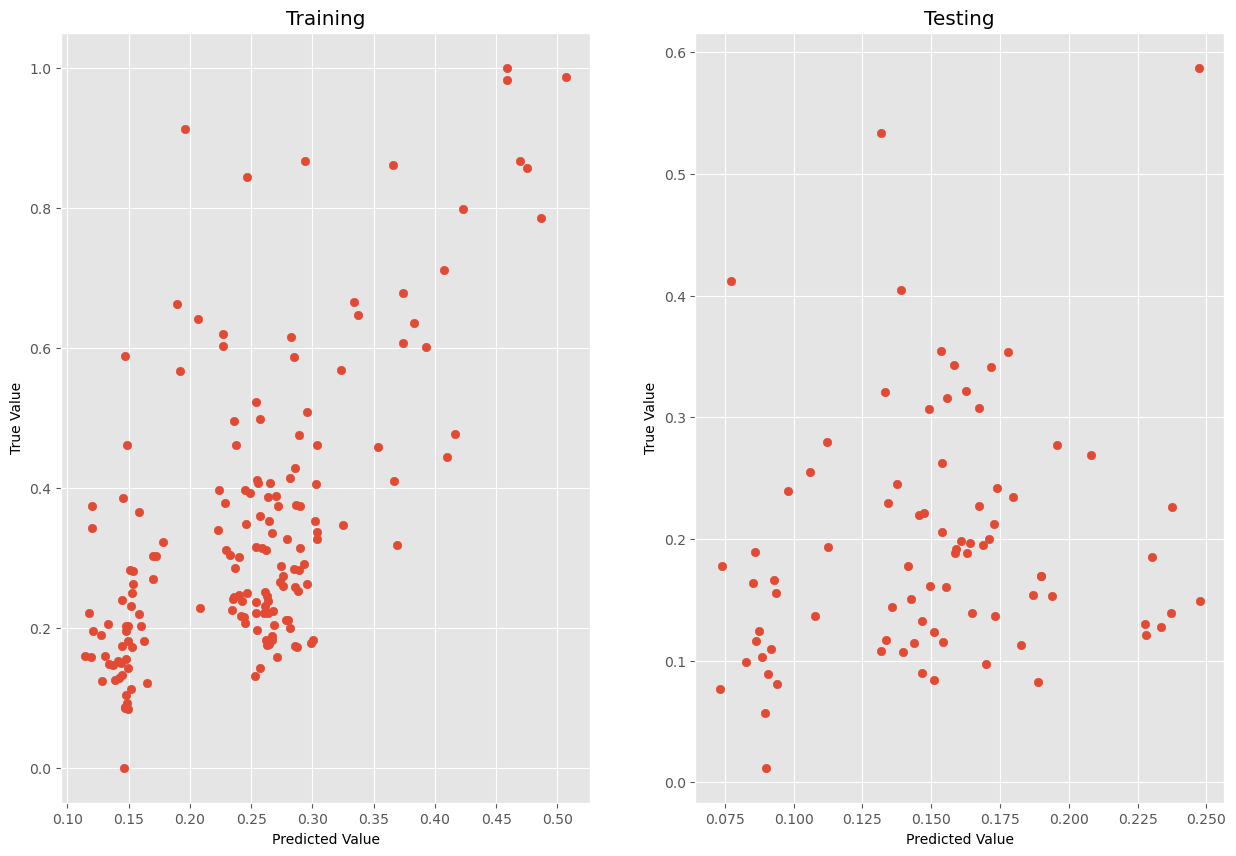

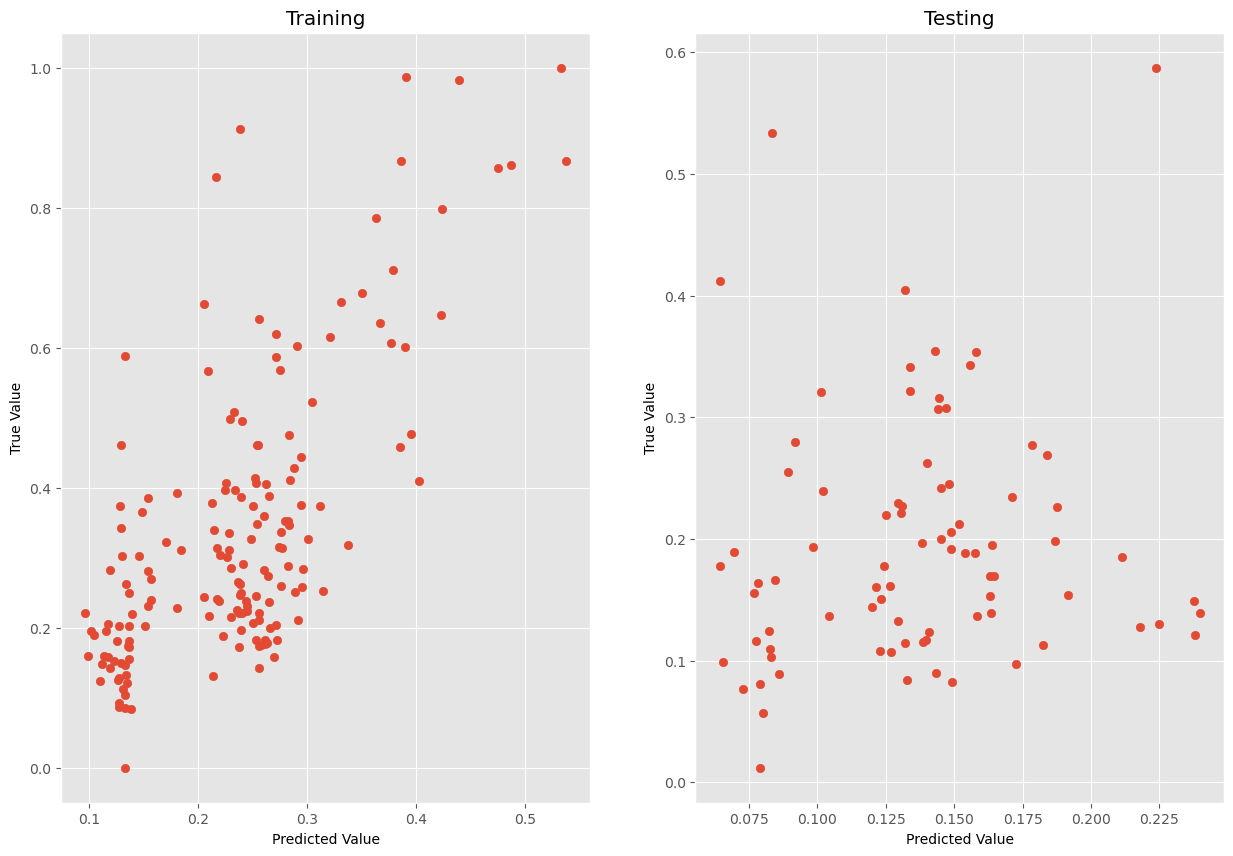

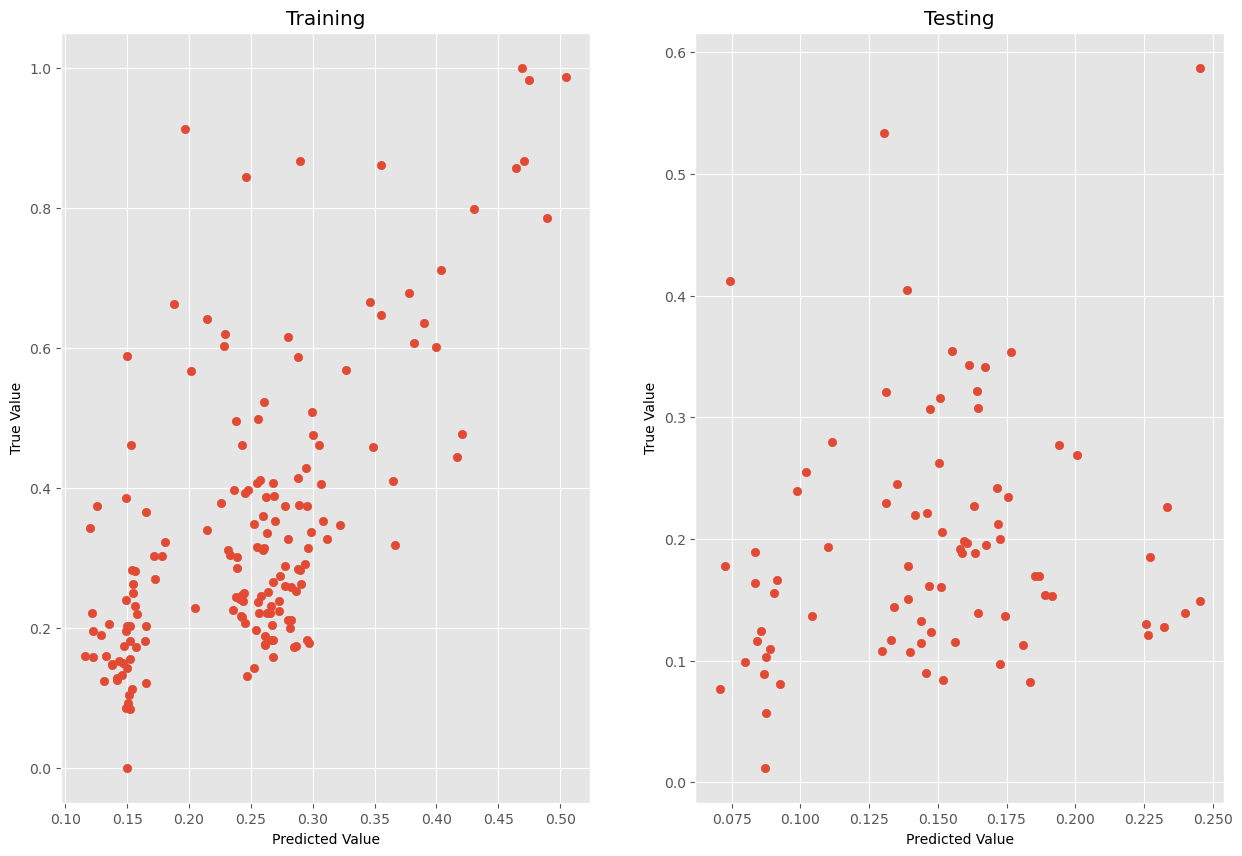

In [82]:
plot_results( t_train_val, t_test_val, y_train_val, y_test_val,)
plot_results( t_train_our, t_test_our, y_train_our, y_test_our,)
plot_results( t_train_mat, t_test_mat, y_train_mat, y_test_mat,)


In [83]:
y_val = np.concatenate((y_train_val,y_test_val))
y_orig = np.concatenate((y_train_our,y_test_our))
y_mat = np.concatenate((y_train_mat,y_test_mat))

y_all = {'Pytorch': y_val, 'Custom': y_mat}

In [100]:
import matplotlib
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)

findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not

Pytorch
Custom


findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not

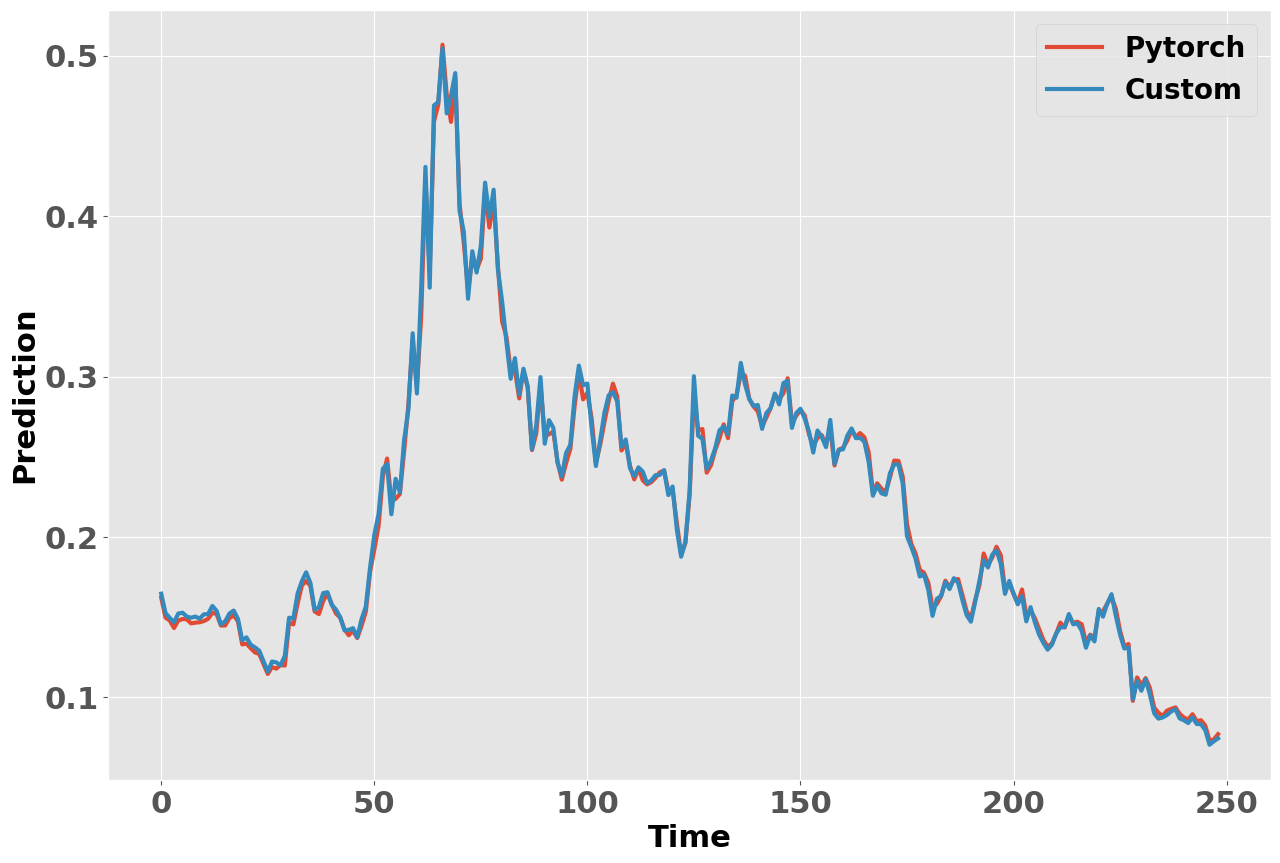

In [101]:
plot_results_time(t_train_val, t_test_val, y_all)

In [85]:
print('validation model')
test_r2(y_train_val, y_test_val, t_train_val, t_test_val)
print('our model')
test_r2(y_train_our, y_test_our, t_train_our, t_test_our)
print('our mat model')
test_r2(y_train_mat, y_test_mat, t_train_mat, t_test_mat)


validation model
The r2 training score is  -4.092860197960562
The r2 testing score is  -5.458349123447589
our model
The r2 training score is  -3.474716168911965
The r2 testing score is  -6.7595651462705995
our mat model
The r2 training score is  -4.009098352329861
The r2 testing score is  -5.527065595364033


In [86]:
print('validation model')
test_mape(y_train_val, y_test_val, t_train_val, t_test_val)
print('our model')
test_mape(y_train_our, y_test_our, t_train_our, t_test_our)
print('our mat model')
test_mape(y_train_mat, y_test_mat, t_train_mat, t_test_mat)


validation model
The mape training score is  0.5370616559844147
The mape testing score is  0.581581127508369
our model
The mape training score is  0.5724406736201071
The mape testing score is  0.7302095274515291
our mat model
The mape training score is  0.5237058597643258
The mape testing score is  0.5979638670424902


In [87]:
for name, param in val_mdl.named_parameters():
    if param.requires_grad:
        print(name,"\n", param.data)
        print(np.shape(param.data))
        print()

lstm.weight_ih_l0 
 tensor([[-1.0592,  0.3669, -0.8753, -1.3222, -0.0462],
        [ 0.0640,  0.0801,  0.8130, -0.6414, -0.5328],
        [ 1.6007,  0.2895,  1.5054,  1.3631,  0.8404],
        [ 0.4173,  0.5443, -0.8435, -0.3851, -0.3990]], dtype=torch.float64)
torch.Size([4, 5])

lstm.weight_hh_l0 
 tensor([[ 0.4608],
        [-0.4889],
        [-0.0474],
        [-0.6749]], dtype=torch.float64)
torch.Size([4, 1])

lstm.bias_ih_l0 
 tensor([-0.5400, -0.6336,  1.4078,  2.5338], dtype=torch.float64)
torch.Size([4])

lstm.bias_hh_l0 
 tensor([0.8586, 0.2774, 2.6141, 0.9772], dtype=torch.float64)
torch.Size([4])



In [88]:
for name, param in our_model_matrix.named_parameters():
    if param.requires_grad:
        print(name,"\n", param.data)
        print(np.shape(param.data))

        print()

weight_ih_l0 
 tensor([[-0.4378,  0.6782, -0.8540, -1.0001, -1.3876],
        [ 1.2123,  0.8189,  0.3652, -0.4462,  1.6651],
        [ 0.5813,  1.1633,  0.9316,  3.2433,  0.1750],
        [ 0.2042, -2.1724,  0.6017,  1.9105, -0.6044]])
torch.Size([4, 5])

weight_hh_l0 
 tensor([[-0.0785],
        [-0.9365],
        [-1.2790],
        [ 1.3609]])
torch.Size([4, 1])

bias_ih_l0 
 tensor([0.1493, 0.0000, 1.4862, 1.8670])
torch.Size([4])

bias_hh_l0 
 tensor([0.1493, 0.0000, 1.4862, 1.8670])
torch.Size([4])



In [89]:
for name, param in our_model.named_parameters():
    if param.requires_grad:
        print(name,"\n", param.data)
        print(np.shape(param.data))

        print()

wf1 
 tensor([[ 0.2724, -0.4527,  0.6035, -0.2718,  0.8480]])
torch.Size([1, 5])

wf2 
 tensor([[1.6514]])
torch.Size([1, 1])

bf 
 tensor([0.4167])
torch.Size([1])

bf2 
 tensor([0.4167])
torch.Size([1])

wi1 
 tensor([[0.1368, 0.4964, 0.6960, 0.5729, 0.5200]])
torch.Size([1, 5])

wi2 
 tensor([[-0.6125]])
torch.Size([1, 1])

bi 
 tensor([0.4740])
torch.Size([1])

bi2 
 tensor([0.4740])
torch.Size([1])

wo1 
 tensor([[-2.6763, -0.6897, -1.9391,  1.1593,  1.2521]])
torch.Size([1, 5])

wo2 
 tensor([[0.6506]])
torch.Size([1, 1])

bo 
 tensor([0.0964])
torch.Size([1])

bo2 
 tensor([0.0964])
torch.Size([1])

wcc1 
 tensor([[ 0.9139, -0.2287,  0.3523,  0.3202, -0.3404]])
torch.Size([1, 5])

wcc2 
 tensor([[0.8839]])
torch.Size([1, 1])

bcc 
 tensor([0.3907])
torch.Size([1])

bcc2 
 tensor([0.3907])
torch.Size([1])

